## Data Loading and Import Library

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [88]:
df = pd.read_csv('data.csv',)
df['ds'] = pd.to_datetime(df['ds'])

## Data Splitting

- **Data Splitting:** The data is split into training and testing sets based on the date. Data points with dates on or before '2023-11-30' are assigned to the training set, while data points with dates after '2023-11-30' are assigned to the testing set.



In [89]:
train = df[df['ds'] <= '2023-11-30']
test = df[df['ds'] > '2023-11-30']

train

,ds,y
0,2023-01-01,658
1,2023-01-02,659
2,2023-01-03,664
3,2023-01-04,772
4,2023-01-05,858
...,...,...
312,2023-11-25,984
313,2023-11-26,594
314,2023-11-28,630
315,2023-11-29,698


##Data set Visualization

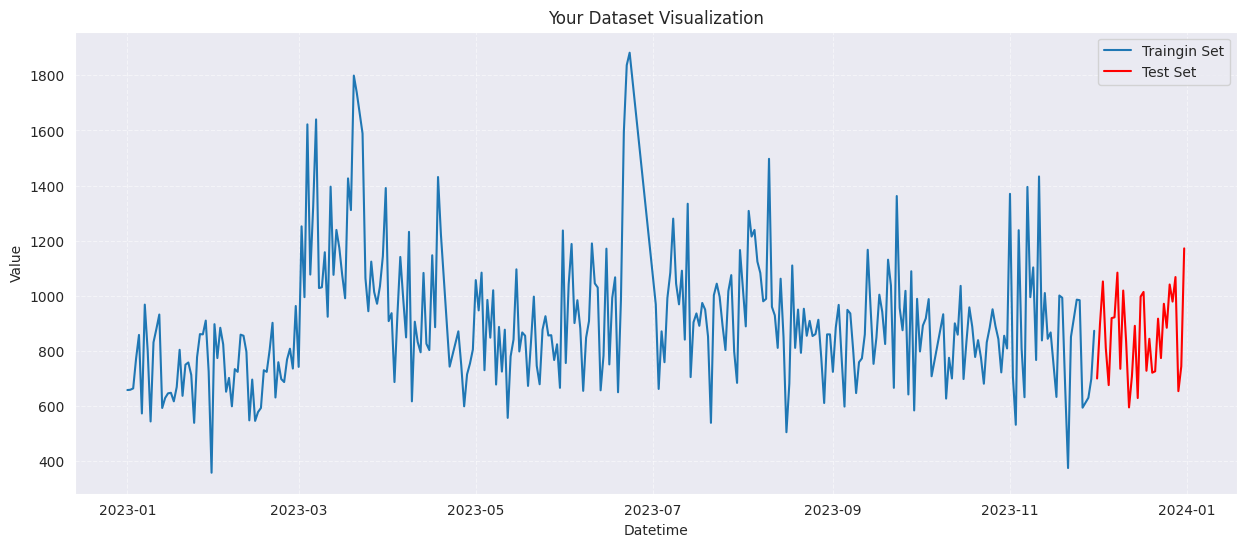

In [90]:
plt.figure(figsize=(15, 6))
plt.plot(train["ds"], train["y"], label="Traingin Set")
plt.plot(test["ds"], test["y"], color='red', label="Test Set")

# Improve visualization
plt.xlabel("Datetime")
plt.ylabel("Value")
plt.title("Your Dataset Visualization")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

### Data Distribution Analysis

Visualizations represent the distribution of the training dataset

Text(0, 0.5, 'Density')

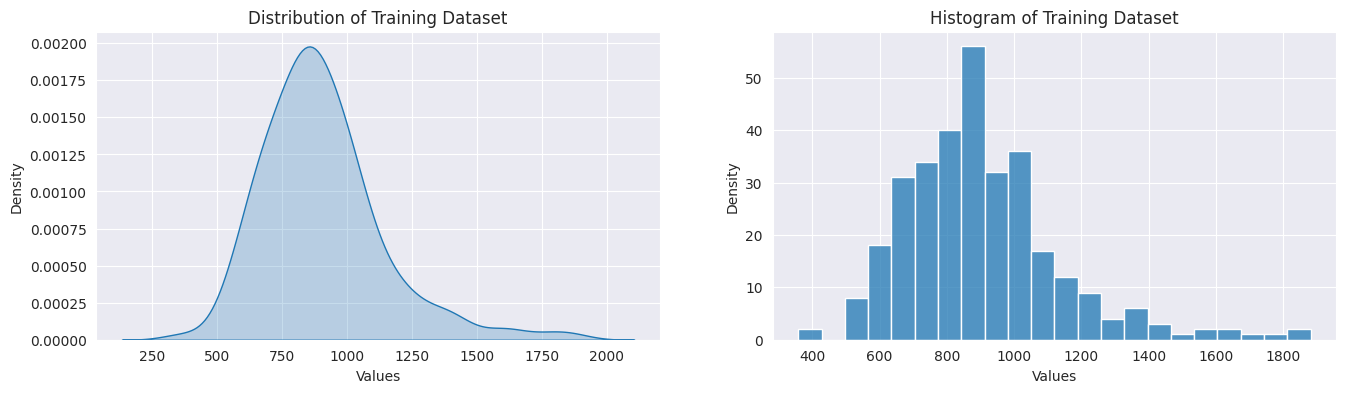

In [91]:

fig, axes = plt.subplots(1,2,  figsize=(16, 4))  # 3 rows, 2 columns


sns.kdeplot(train['y'], fill=True, ax=axes[0])
axes[0].set_title('Distribution of Training Dataset')
axes[0].set_xlabel('Values')
axes[0].set_ylabel('Density')

# Plot the histplot on the second subplot
# Access the correct Axes object using indexing
sns.histplot(train['y'], ax=axes[1])
axes[ 1].set_title('Histogram of Training Dataset')
axes[ 1].set_xlabel('Values')
axes[ 1].set_ylabel('Density')

### ACF and PACF Analysis

- **Autocorrelation Function (ACF)**: Shows how current values relate to past values at different lags.
- **Partial Autocorrelation Function (PACF)**: Helps identify the direct effect of a lag on the current value
- Useful for determining AR and MA terms in ARIMA modeling.


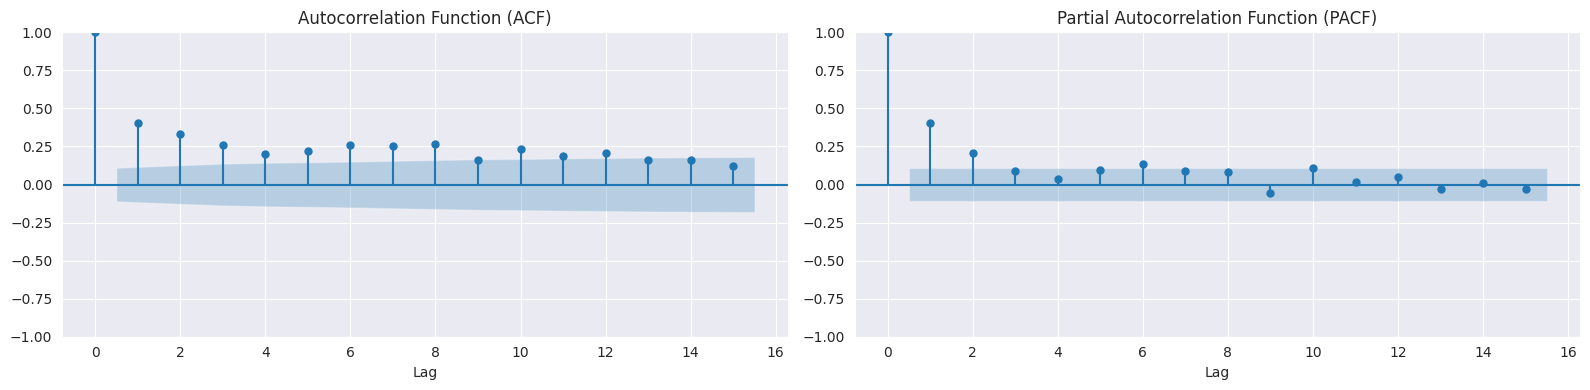

In [92]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF Plot
plot_acf(train['y'], ax=axes[0], lags=15)
axes[0].set_title("Autocorrelation Function (ACF)")
axes[0].set_xlabel("Lag")


# PACF Plot
plot_pacf(train['y'], ax=axes[1], lags=15)
axes[1].set_title("Partial Autocorrelation Function (PACF)")
axes[1].set_xlabel("Lag")

plt.tight_layout()
plt.show()

### ARIMA Model Selection

- **Purpose**: Iterates over different ARIMA (p,d,q) parameters to find the best model based on the Akaike Information Criterion (AIC).
- **AIC Metric**: Lower values indicate a better-fitting model.

In [93]:
import warnings
warnings.filterwarnings("ignore")

ar = [1,2]
ma = [1,2,3]
di = [0,1]

best_aic = float('inf')
best_params = None

for p in ar:
  for d in di:
    for q in ma:
      model = ARIMA(train['y'], order=(p, d, q))
      model_fit = model.fit()
      print(f'ARIMA({p},{d},{q}) - AIC: {model_fit.aic}')
      if model_fit.aic < best_aic:
        best_aic = model_fit.aic
        best_params = (p, d, q)

ARIMA(1,0,1) - AIC: 4290.640129278258
ARIMA(1,0,2) - AIC: 4290.332675975223
ARIMA(1,0,3) - AIC: 4290.979987857514
ARIMA(1,1,1) - AIC: 4279.86963311964
ARIMA(1,1,2) - AIC: 4281.210366228588
ARIMA(1,1,3) - AIC: 4282.453179329876
ARIMA(2,0,1) - AIC: 4289.937597983782
ARIMA(2,0,2) - AIC: 4291.573851133871
ARIMA(2,0,3) - AIC: 4292.932141295967
ARIMA(2,1,1) - AIC: 4280.775231342949
ARIMA(2,1,2) - AIC: 4282.744448496658
ARIMA(2,1,3) - AIC: 4275.642890680546


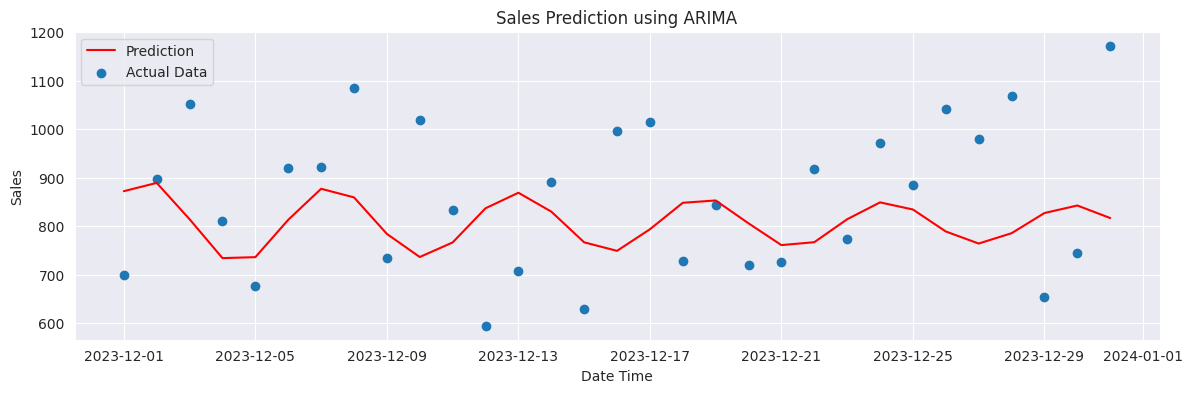

In [94]:
arima_model = ARIMA(train['y'], order=(best_params))
model_fit = arima_model.fit()
arima_pred = model_fit.forecast(len(test))


plt.figure(figsize=(14,4))
plt.plot(test['ds'],arima_pred,label='Prediction',color='red')
plt.scatter(test['ds'],test['y'],label='Actual Data')
plt.title('Sales Prediction using ARIMA')
plt.xlabel('Date Time')
plt.ylabel('Sales')
plt.legend()

#**Fit Prophet Model**

In [95]:
from prophet import Prophet

fb_model = Prophet()
fb_model.fit(train[["ds","y"]])

fb_pred = fb_model.predict()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl7kqngbn/a1h4r3um.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl7kqngbn/pz76gro_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76580', 'data', 'file=/tmp/tmpl7kqngbn/a1h4r3um.json', 'init=/tmp/tmpl7kqngbn/pz76gro_.json', 'output', 'file=/tmp/tmpl7kqngbn/prophet_model00olvnnr/prophet_model-20250224135505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:55:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:55:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


#**Fit The LinearRegression Model**

In [96]:
from sklearn.linear_model import LinearRegression

data = df[['ds','y']].copy()

data["month"] = data["ds"].dt.month
data["day"] = data["ds"].dt.day
data["dayofweek"] = data["ds"].dt.dayofweek
data["dayofyear"] = data["ds"].dt.dayofyear
data["quarter"] = data["ds"].dt.quarter
data["is_month_start"] = data["ds"].dt.is_month_start
data["is_month_end"] = data["ds"].dt.is_month_end

x_train = data[data["ds"] <= "2023-11-30"].drop(["ds", "y"], axis=1)
y_train = data[data["ds"] <= "2023-11-30"]["y"]

x_test = data[data["ds"] > "2023-11-30"].drop(["ds", "y"], axis=1)
y_test = data[data["ds"] > "2023-11-30"]["y"]


lr = LinearRegression()
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)

## **Prediction Plot: ( Linear Regression, Prophet, and ARIMA )**

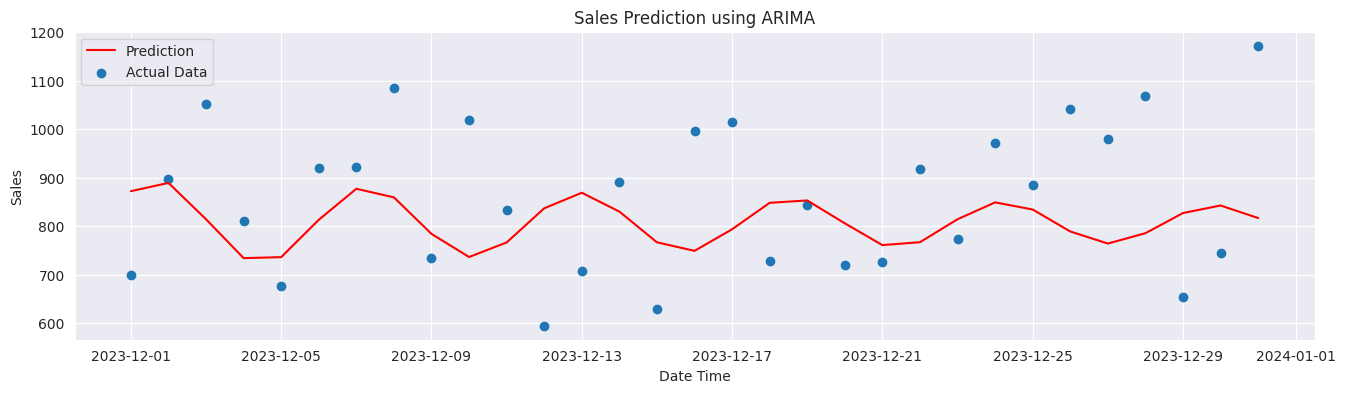

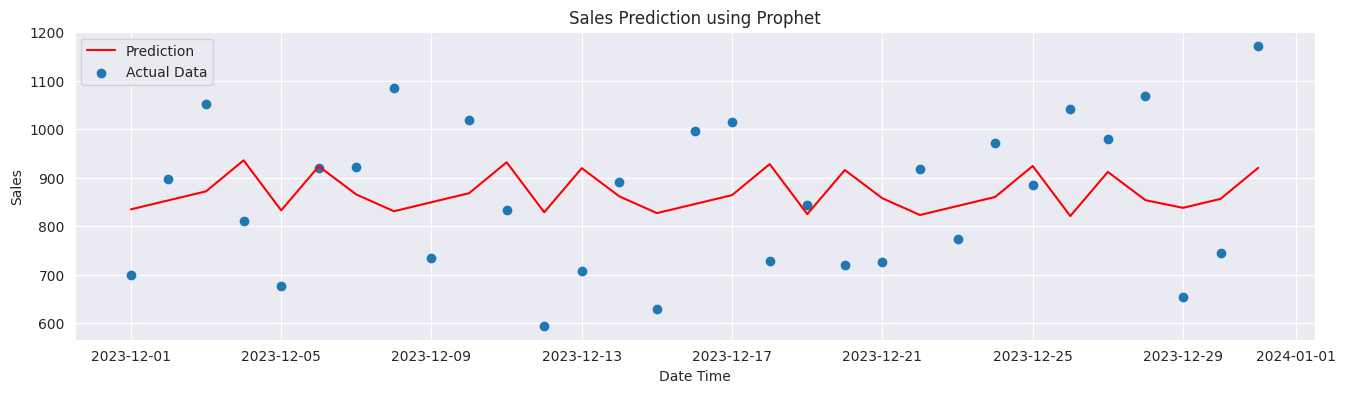

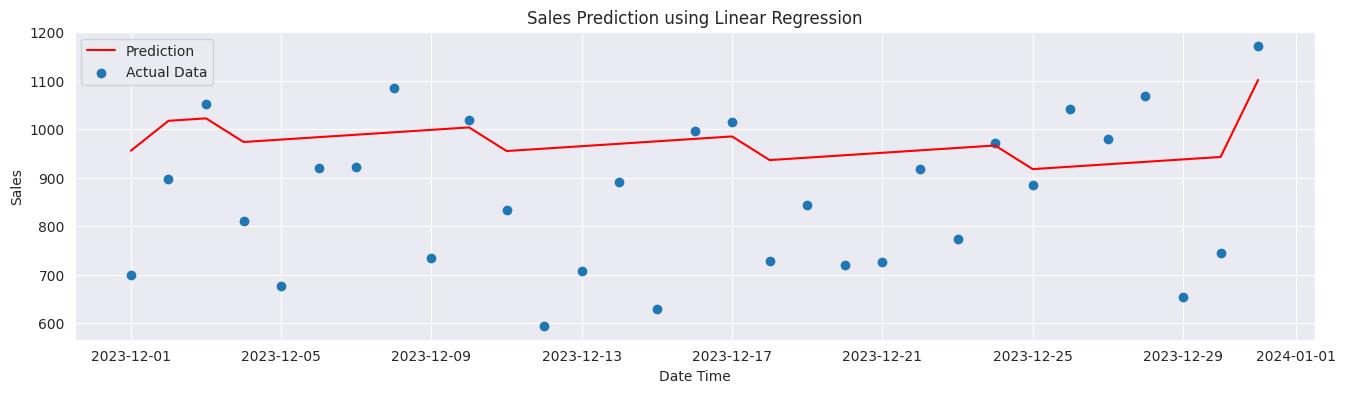

In [97]:
# plot ARIMA model Predictions
plt.figure(figsize=(16,4))
plt.plot(test['ds'],arima_pred,label='Prediction',color='red')
plt.scatter(test['ds'],test['y'],label='Actual Data')
plt.title('Sales Prediction using ARIMA')
plt.xlabel('Date Time')
plt.ylabel('Sales')
plt.legend()


# plot prophet model Predictions
plt.figure(figsize=(16,4))
plt.plot(test['ds'],fb_pred.yhat.tail(len(test)),label='Prediction',color='red')
plt.scatter(test['ds'],test['y'],label='Actual Data')
plt.title('Sales Prediction using Prophet')
plt.xlabel('Date Time')
plt.ylabel('Sales')
plt.legend()

# plot LinearRegression model Predictions
plt.figure(figsize=(16,4))
plt.plot(test['ds'],lr_pred,label='Prediction',color='red')
plt.scatter(test['ds'],test['y'],label='Actual Data')
plt.title('Sales Prediction using Linear Regression')
plt.xlabel('Date Time')
plt.ylabel('Sales')
plt.legend()

### **Error Metrics Calculation**

 The following functions compute different error metrics to evaluate the accuracy of predictions:

- **Root Mean Squared Error (RMSE)**:
 - Measures the square root of the average squared differences between predicted and actual values.

  
- **Mean Absolute Error (MAE)**:
 - Calculates the average absolute difference between predicted and actual values.


- **Mean Absolute Percentage Error (MAPE)**:
 - Measures the percentage difference between predicted and actual values.
  



In [98]:
#RMSE
def Calculate_Error_RMSE(test_pred):
  errors = list()
  for i in range(test.shape[0]):
    err = np.sqrt((test_pred[i] - test['y'].values[i])**2)
    errors.append(err)
  return errors


#MAE
def Calculate_Error_MAE(test_pred):
  errors = list()
  for i in range(test.shape[0]):
    err = np.abs((test_pred[i] - test['y'].values[i]))
    errors.append(err)
  return errors


#MAPE
def Calculate_Error_MAPE(test_pred):
  errors = list()
  for i in range(test.shape[0]):
    err = np.abs((test_pred[i] - test['y'].values[i]) / test['y'].values[i])
    errors.append(err)
  return errors

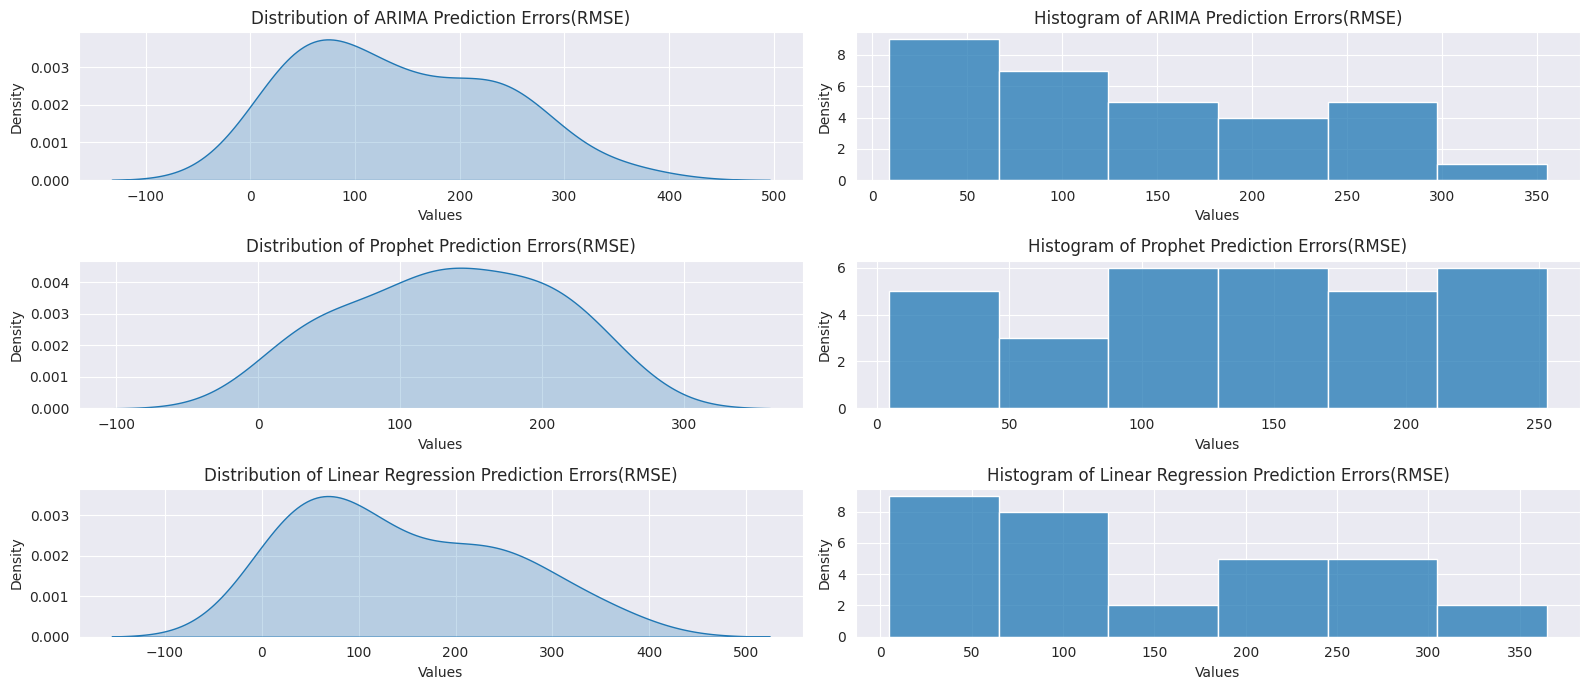

In [99]:

fig, axes = plt.subplots(3, 2, figsize=(16, 7))  # 3 rows, 2 columns


arima_errors = Calculate_Error_RMSE(arima_pred.values)
fbProphet_errors = Calculate_Error_RMSE(fb_pred.yhat.tail(len(test)).values)
lr_errors = Calculate_Error_RMSE(lr_pred)

# Plot the kdeplot on the first subplot
# Access the correct Axes object using indexing
sns.kdeplot(arima_errors, fill=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of ARIMA Prediction Errors(RMSE)')
axes[0, 0].set_xlabel('Values')
axes[0, 0].set_ylabel('Density')

# Plot the histplot on the second subplot
# Access the correct Axes object using indexing
sns.histplot(arima_errors, ax=axes[0, 1])
axes[0, 1].set_title('Histogram of ARIMA Prediction Errors(RMSE)')
axes[0, 1].set_xlabel('Values')
axes[0, 1].set_ylabel('Density')

# ... (similarly for other plots)
sns.kdeplot(fbProphet_errors, fill=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Prophet Prediction Errors(RMSE)')
axes[1, 0].set_xlabel('Values')
axes[1, 0].set_ylabel('Density')

sns.histplot(fbProphet_errors, ax=axes[1, 1])
axes[1, 1].set_title('Histogram of Prophet Prediction Errors(RMSE)')
axes[1, 1].set_xlabel('Values')
axes[1, 1].set_ylabel('Density')

sns.kdeplot(lr_errors, fill=True, ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Linear Regression Prediction Errors(RMSE)')
axes[2, 0].set_xlabel('Values')
axes[2, 0].set_ylabel('Density')

sns.histplot(lr_errors, ax=axes[2, 1])
axes[2, 1].set_title('Histogram of Linear Regression Prediction Errors(RMSE)')
axes[2, 1].set_xlabel('Values')
axes[2, 1].set_ylabel('Density')

plt.tight_layout()
plt.show()

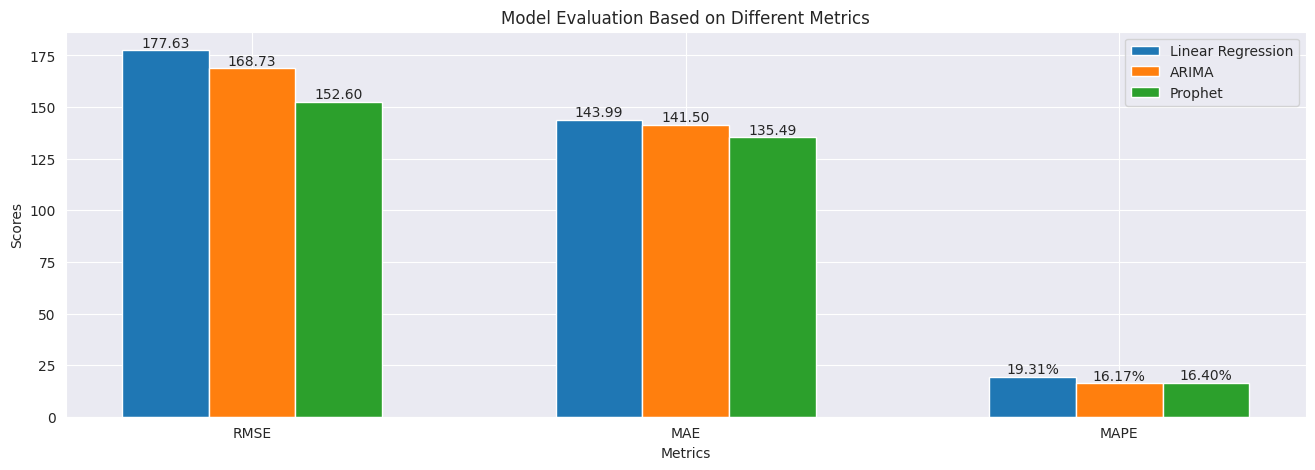

In [100]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error,root_mean_squared_error

# Data
models = ['Linear Regression', 'ARIMA', 'Prophet']
metrics = ['RMSE', 'MAE', 'MAPE']

lr_rmse = root_mean_squared_error(test['y'], lr_pred)
arima_rmse = root_mean_squared_error(test['y'], arima_pred)
fb_rmse = root_mean_squared_error(test['y'], fb_pred.yhat.tail(len(test)).values)

lr_mae = mean_absolute_error(test['y'], lr_pred)
arima_mae = mean_absolute_error(test['y'], arima_pred)
fb_mae = mean_absolute_error(test['y'], fb_pred.yhat.tail(len(test)).values)

lr_mape = mean_absolute_percentage_error(test['y'], lr_pred) * 100
arima_mape = mean_absolute_percentage_error(test['y'], arima_pred) * 100
fb_mape = mean_absolute_percentage_error(test['y'], fb_pred.yhat.tail(len(test)).values) * 100



values = {
    'Linear Regression': [lr_rmse,lr_mae,lr_mape],
    'ARIMA': [arima_rmse,arima_mae,arima_mape],
    'Prophet': [fb_rmse,fb_mae,fb_mape]
}

# Bar properties
x = np.arange(len(metrics))  # the label locations
width = 0.2  # the width of the bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Colors for bars

# Plotting
fig, ax = plt.subplots(figsize=(16, 5))
for i, model in enumerate(models):
    bars = ax.bar(x + i * width, values[model], width, label=model, color=colors[i])
    for j, bar in enumerate(bars):
        yval = bar.get_height()
        if metrics[j] == 'MAPE':
            ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom')
        else:
            ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

# Labels and formatting
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Evaluation Based on Different Metrics')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()

# Show plot
plt.show()

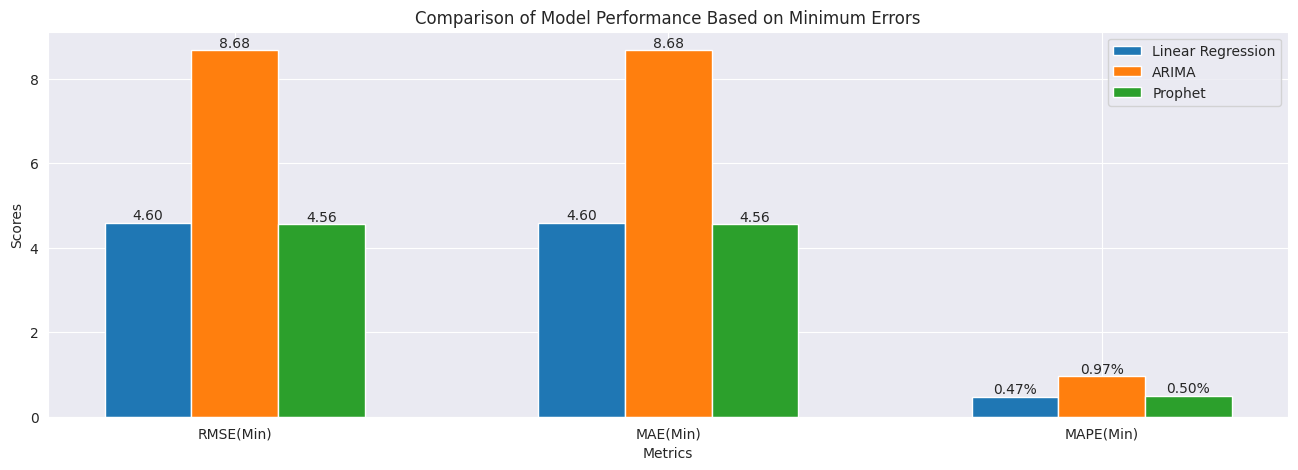

In [101]:
lr_Min_rmse = np.min(lr_errors)
arima_Min_rmse = np.min(arima_errors)
fb_Min_rmse = np.min(fbProphet_errors)

lr_Min_mae = np.min(Calculate_Error_MAE(lr_pred))
arima_Min_mae = np.min(Calculate_Error_MAE(arima_pred.values))
fb_Min_mae = np.min(Calculate_Error_MAE(fb_pred.yhat.tail(len(test)).values))

lr_Min_mape = np.min(Calculate_Error_MAPE(lr_pred)) * 100
arima_Min_mape = np.min(Calculate_Error_MAPE(arima_pred.values)) * 100
fb_Min_mape = np.min(Calculate_Error_MAPE(fb_pred.yhat.tail(len(test)).values)) * 100



# Data
models = ['Linear Regression', 'ARIMA', 'Prophet']
metrics = ['RMSE(Min)', 'MAE(Min)', 'MAPE(Min)']


values = {
    'Linear Regression': [lr_Min_rmse,lr_Min_mae,lr_Min_mape],
    'ARIMA': [arima_Min_rmse,arima_Min_mae,arima_Min_mape],
    'Prophet': [fb_Min_rmse,fb_Min_mae,fb_Min_mape]
}

# Bar properties
x = np.arange(len(metrics))  # the label locations
width = 0.2  # the width of the bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Colors for bars

# Plotting
fig, ax = plt.subplots(figsize=(16, 5))
for i, model in enumerate(models):
    bars = ax.bar(x + i * width, values[model], width, label=model, color=colors[i])
    for j, bar in enumerate(bars):
        yval = bar.get_height()
        if metrics[j] == 'MAPE(Min)':
            ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom')
        else:
            ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

# Labels and formatting
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance Based on Minimum Errors')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()

# Show plot
plt.show()

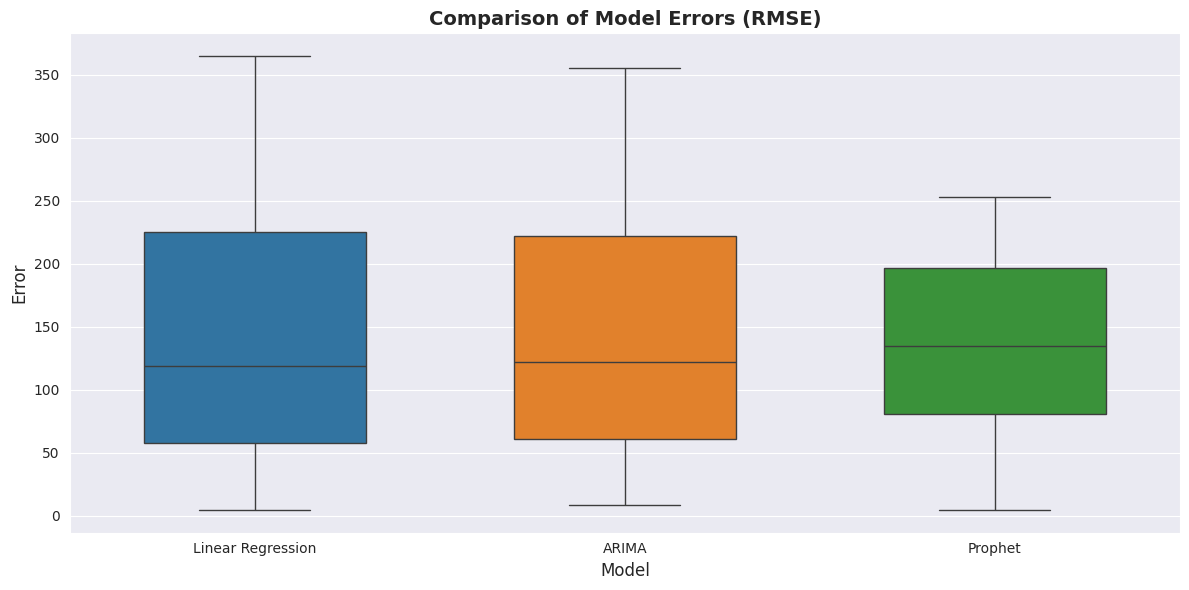

In [113]:

# Create a DataFrame
model_data = [
    ("Linear Regression", lr_errors),
    ("ARIMA", arima_errors),
    ("Prophet", fbProphet_errors),
]


# Convert to a format suitable for seaborn
all_errors = []
model_names = []
for model_name, errors in model_data:
    all_errors.extend(errors)
    model_names.extend([model_name] * len(errors))

error_df = pd.DataFrame({"Model": model_names, "Error": all_errors})

# Set Seaborn style
sns.set_style("darkgrid")

# Create the figure
plt.figure(figsize=(12, 6))

# Boxplot with custom colors
palette = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Custom color palette
sns.boxplot(x="Model", y="Error", data=error_df, palette=palette, width=0.6)


# Labels and title
plt.title("Comparison of Model Errors (RMSE)", fontsize=14, fontweight="bold")
plt.xlabel("Model", fontsize=12)
plt.ylabel("Error", fontsize=12)

# Adjust layout and show plot
plt.tight_layout()
plt.show()